@todo: batch effects from the 

# 0. Load data

In [88]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None,
                    measurement_level_name:str='Measurement'):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      feature_selection.SelectFromModel(classifier()),
                                      classifier() )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    
import umap

# Suppress batch effects
def scale_by_region(df):
    scaled = []
    for region,_df in df.groupby('Region'):
        _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
        _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,
                           data=_X)
        _df['Region'] = region
        scaled.append(_df)
    return pd.concat(scaled)
    

### Separate measurement fields into constituent types

In [564]:
from functools import reduce

measurement_types = basals.columns.get_level_values(1)

#Intrinsics
shapes = basals.columns[ (measurement_types.str.contains('shape') | measurement_types.str.contains('shcoeff'))
                         & ~measurement_types.str.contains('adjac') & ~measurement_types.str.contains('elative')]
drop = [f for f in shapes if 'Manual' in f[0]]
shapes = shapes.drop(drop)

position = basals.columns[(measurement_types == 'Measurement cell position')]
h2b = basals.columns[(measurement_types == 'Measurement H2B') | (measurement_types == 'Measurement H2B rate')]
fucci = basals.columns[(measurement_types == 'Measurement FUCCI') | (measurement_types == 'Measurement FUCCI rate')]
intrinsic_features = reduce(list.__add__, [f.tolist() for f in [shapes,position,h2b,fucci]])

# Environment
tissue_geom = basals.columns[measurement_types.str.contains('Measurement tissue geometry')]
collagen = basals.columns[measurement_types.str.contains('ollagen')]
tissue_topo = basals.columns[measurement_types == 'Measurement topology']
adjac_shape = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('shape'))
                | (measurement_types.str.contains('adjac') & measurement_types.str.contains('shcoeff'))]
drop = [f for f in adjac_shape if 'Manual' in f[0]]
adjac_shape = adjac_shape.drop(drop)

adjac_fucci = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('FUCCI'))
                            | (measurement_types.str.contains('relative') & measurement_types.str.contains('FUCCI'))]
adjac_h2b = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('H2B'))
                            | (measurement_types.str.contains('relative') & measurement_types.str.contains('H2B'))]
relative_shape = basals.columns[(measurement_types.str.contains('relative') & measurement_types.str.contains('shape'))
                                 | (measurement_types.str.contains('relative') & measurement_types.str.contains('shcoeff'))]
drop = [f for f in relative_shape if 'Manual' in f[0] or 'rate' in f[0]]
relative_shape = relative_shape.drop(drop)

extrinsic_features = reduce(list.__add__, [f.tolist() for f in [tissue_geom,collagen,tissue_topo,adjac_shape,adjac_fucci,adjac_h2b,relative_shape]])

#Other
times = basals.columns[measurement_types == 'Measurement time']
metas = basals.columns[measurement_types == 'Meta']

accounted_for = set(intrinsic_features).union(set(extrinsic_features))
set(basals.columns) - accounted_for

{('Age', 'Measurement time'),
 ('Birth frame', 'Meta'),
 ('Border', 'Meta'),
 ('Born', 'Meta'),
 ('Cell cycle phase', 'Meta'),
 ('Cell cycle transition', 'Meta'),
 ('Cell type', 'Meta'),
 ('Complete cycle', 'Meta'),
 ('Cutoff', 'Meta'),
 ('Daughter a', 'Meta'),
 ('Daughter b', 'Meta'),
 ('Delaminate next frame', 'Meta'),
 ('Differentiated', 'Meta'),
 ('Divide next frame', 'Meta'),
 ('Division', 'Meta'),
 ('Fate known', 'Meta'),
 ('Frac of neighbors are border', 'Meta'),
 ('Frac of neighbors in S phase', 'Meta'),
 ('Keep until first differentiation', 'Meta'),
 ('Left', 'Meta'),
 ('LineageID', 'Meta'),
 ('Manual cell volume', 'Measurement cell shape'),
 ('Max adjac Manual cell volume', 'Measurement cell shape adjac'),
 ('Mean adjac Manual cell volume', 'Measurement cell shape adjac'),
 ('Median adjac Manual cell volume', 'Measurement cell shape adjac'),
 ('Min adjac Manual cell volume', 'Measurement cell shape adjac'),
 ('Mother', 'Meta'),
 ('Region', ''),
 ('Relative Cell volume G1 only

In [575]:
# Standardize

extrinsic_measurements = basals[extrinsic_features]
features2drop = extrinsic_measurements.columns[extrinsic_measurements.isna().sum() > 200]
extrinsic_measurements = extrinsic_measurements.drop(columns=features2drop)
extrinsic_measurements = extrinsic_measurements.dropna(axis=0)
extrinsic_measurements['Region'] = basals['Region']

meas_scaled_by_region = scale_by_region(extrinsic_measurements)
scaled_data = meas_scaled_by_region.dropna(axis=0)

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/2673402985.py:72: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/2673402985.py:73: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,


In [576]:
extrinsic_measurements.isna().sum()

BM height                         Measurement tissue geometry         0
Height to BM                      Measurement tissue geometry         0
Mean curvature - cell coords      Measurement tissue geometry         0
Gaussian curvature - cell coords  Measurement tissue geometry         0
Mean curvature 2um                Measurement tissue geometry         0
                                                                     ..
Relative shcoeff_PC5              Measurement shcoeff_PCA relative    0
Relative shcoeff_PC6              Measurement shcoeff_PCA relative    0
Relative shcoeff_PC7              Measurement shcoeff_PCA relative    0
Relative shcoeff_PC8              Measurement shcoeff_PCA relative    0
Region                                                                0
Length: 330, dtype: int64

# 1. U-map

[https://github.com/CoAxLab/pycombat]
These input data consist of the following ingredients:

    Y: The matrix of response variables, with dimensions [observations x features]
    b: The array of batch label for each observation. In principle these could be labelled as numbers or strings.
    X: The matrix of effects of interest to keep, with dimensions [observations x features_interest]
    C: The matrix of covariates to remove, with dimensions [observations x features_covariates]


### Try a bunch of hyperparameters

In [577]:
pd.merge(scaled_data,basals['Cell cycle phase','Meta'],left_index=True,right_index=True)

BM height                Height to BM  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -2.255796                    0.639301   
1     1                         -1.861901                    0.460889   
2     1                         -1.074109                    1.055903   
3     1                         -0.286318                    1.260528   
4     1                         -0.680214                    1.709475   
...                                   ...                         ...   
0     1166                      -1.861901                    0.758223   
      1191                      -2.649692                   -1.521773   
      1195                      -1.861901                    0.228229   
      1196                      -1.468005                    0.735781   
      1197                      -2.255796                    0.780995   

              Mean curvature - cell coords Gaussian curvature - cell coords  \
               Measurement tissue geometry      Measurement tissue geometry   
Frame TrackID                                                                 
0     1                          -1.579707                        -0.164560   
1     1                          -1.292504                         0.176855   
2     1                          -1.328134                         0.493168   
3     1                          -1.835271                        -0.015911   
4     1                          -2.049329                         0.106327   
...                                    ...                              ...   
0     1166                       -2.496556                        -0.864284   
      1191                       -1.480231                        -0.442926   
      1195                       -2.418250                        -0.736655   
      1196                       -2.579430                        -0.752901   
      1197                       -2.047841                        -0.158729   

                       Mean curvature 2um      Gaussian curvature 2um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -1.569460                    0.376876   
1     1                         -1.378499                    0.121699   
2     1                         -1.088642                    0.830103   
3     1                         -1.760629                    0.394366   
4     1                         -2.059485                    0.720888   
...                                   ...                         ...   
0     1166                       0.172416                    0.039280   
      1191                       1.160135                    0.102125   
      1195                      -0.528961                    0.784414   
      1196                      -1.056671                    0.611766   
      1197                       0.201162                    0.559076   

                       Mean curvature 5um      Gaussian curvature 5um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -1.916013                    0.599858   
1     1                         -1.713065                    0.245207   
2     1                         -1.745892                    0.252194   
3     1                         -1.283329                   -0.090297   
4     1                         -1.391225                   -0.193614   
...                                   ...                         ...   
0     1166                       0.369719                   -0.192992   
      1191                       0.885398                   -0.055703   
      1195                      -1.346061                    0.498126   
   

In [578]:
from itertools import product

_mapped = pd.DataFrame(index=scaled_data.index)
_mapped['Region'] = scaled_data['Region']
_mapped['Cell state'] = pd.merge(scaled_data,basals['Cell cycle phase','Meta'],left_index=True,right_index=True)['Cell cycle phase','Meta']
_mapped.loc[basals['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[basals['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[basals['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
_mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

num_neighbors2try = [5,10,25]
min_dist2try = [0.0,0.1,0.2,0.5,0.8,1]
parameters = product(num_neighbors2try,min_dist2try)
mapped = []

for num_neighbors,min_dist in tqdm(parameters):
    
    reducer = umap.UMAP(n_neighbors=num_neighbors,min_dist=min_dist)
    embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Num neighbors'] = num_neighbors
    _this_mapped['Min dist'] = min_dist

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

0it [00:00, ?it/s]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/1724255364.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
1it [00:12, 12.13s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/1724255364.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
2it [00:23, 11.95s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/1724255364.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
3it [00:36, 12.24s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/1724255364.py:19: PerformanceWarning: dropping on a non-

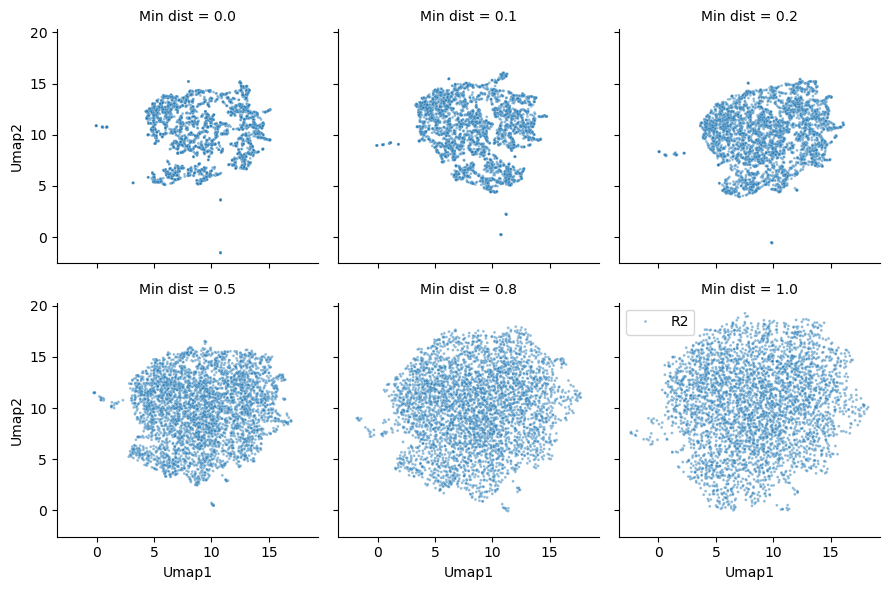

In [579]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped[mapped['Num neighbors']==5],col_wrap=3,col='Min dist')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Region',alpha=0.5)
plt.legend()

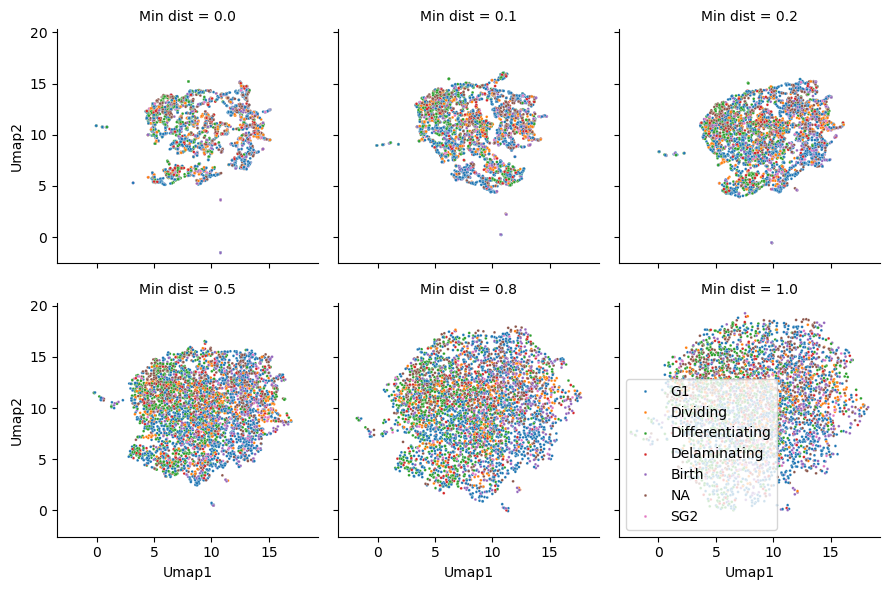

In [580]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped[mapped['Num neighbors']==5],col_wrap=3,col='Min dist')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Cell state',alpha=1)
plt.legend()

Obvious batch effects... but is it biological?

### Stability test

In [581]:
Niter = 6

_mapped = pd.DataFrame(index=scaled_data.index)
_mapped['Region'] = scaled_data['Region']
_mapped['Cell state'] = pd.merge(scaled_data,basals['Cell cycle phase','Meta'],left_index=True,right_index=True)['Cell cycle phase','Meta']

meta_cols = basals.xs('Meta',level=1,axis=1).columns
_df = pd.merge(scaled_data, basals[[(f,'Meta') for f in meta_cols]],left_index=True,right_index=True)

_mapped.loc[_df['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[_df['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[_df['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
_mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

mapped = []
for i in tqdm(range(Niter)):
    
    reducer = umap.UMAP(n_neighbors=5,min_dist=1)
    embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Umap run'] = i

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

  0%|                                                        | 0/6 [00:00<?, ?it/s]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/3335655017.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
 17%|████████                                        | 1/6 [00:11<00:59, 11.84s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/3335655017.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
 33%|████████████████                                | 2/6 [00:24<00:50, 12.61s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/3335655017.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_tr

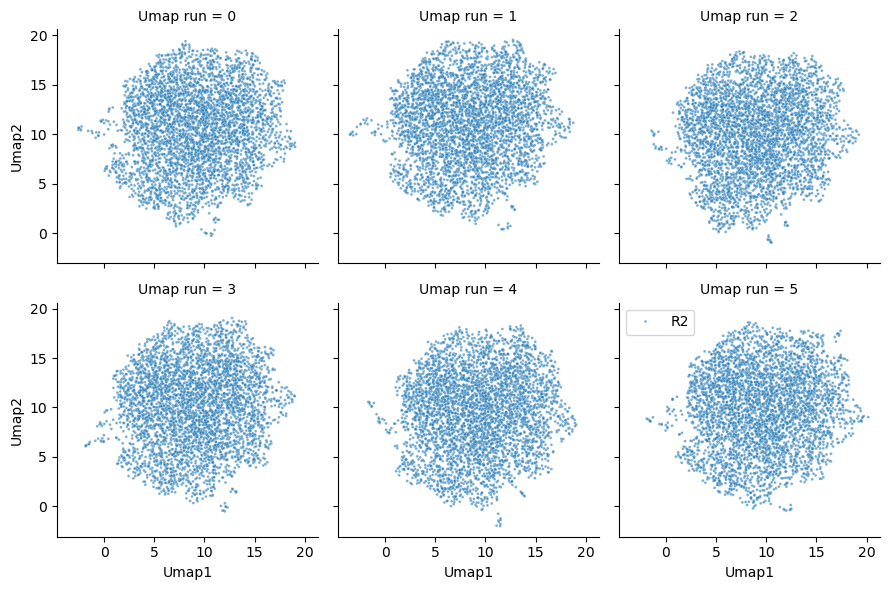

In [582]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped,col_wrap=3,col='Umap run')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Region',alpha=0.6)
plt.legend()

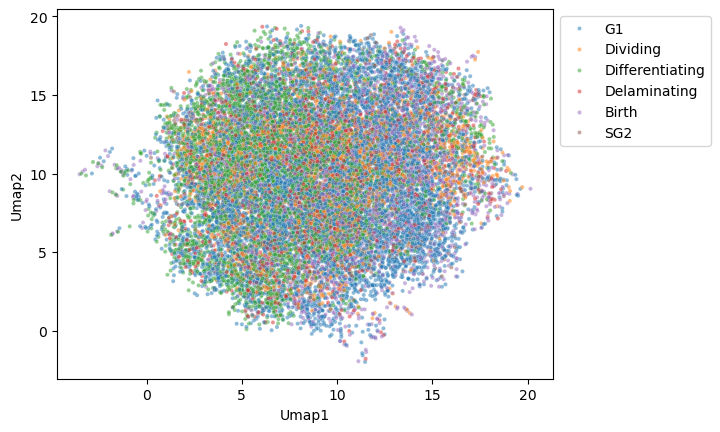

In [624]:
mpl.rcParams['lines.markersize'] = 3              # <---- set markersize here

sb.scatterplot(data=mapped[mapped['Cell state'] != 'NA'],x='Umap1',y='Umap2',
                hue='Cell state',alpha=0.5)
plt.legend(bbox_to_anchor=(1,1))


Basicallly, all UMAP runs returns similar graphs

## Visualize UMAPs alongside cell state annotation

In [625]:
mpl.rcParams['lines.markersize'] = 5              # <---- set markersize here

df = pd.merge(scaled_data, basals[[(f,'Meta') for f in meta_cols]],left_index=True,right_index=True)

df['Umap1'] = embedding[:,0]
df['Umap2'] = embedding[:,1]
df

BM height                Height to BM  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -2.255796                    0.639301   
1     1                         -1.861901                    0.460889   
2     1                         -1.074109                    1.055903   
3     1                         -0.286318                    1.260528   
4     1                         -0.680214                    1.709475   
...                                   ...                         ...   
0     1166                      -1.861901                    0.758223   
      1191                      -2.649692                   -1.521773   
      1195                      -1.861901                    0.228229   
      1196                      -1.468005                    0.735781   
      1197                      -2.255796                    0.780995   

              Mean curvature - cell coords Gaussian curvature - cell coords  \
               Measurement tissue geometry      Measurement tissue geometry   
Frame TrackID                                                                 
0     1                          -1.579707                        -0.164560   
1     1                          -1.292504                         0.176855   
2     1                          -1.328134                         0.493168   
3     1                          -1.835271                        -0.015911   
4     1                          -2.049329                         0.106327   
...                                    ...                              ...   
0     1166                       -2.496556                        -0.864284   
      1191                       -1.480231                        -0.442926   
      1195                       -2.418250                        -0.736655   
      1196                       -2.579430                        -0.752901   
      1197                       -2.047841                        -0.158729   

                       Mean curvature 2um      Gaussian curvature 2um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -1.569460                    0.376876   
1     1                         -1.378499                    0.121699   
2     1                         -1.088642                    0.830103   
3     1                         -1.760629                    0.394366   
4     1                         -2.059485                    0.720888   
...                                   ...                         ...   
0     1166                       0.172416                    0.039280   
      1191                       1.160135                    0.102125   
      1195                      -0.528961                    0.784414   
      1196                      -1.056671                    0.611766   
      1197                       0.201162                    0.559076   

                       Mean curvature 5um      Gaussian curvature 5um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -1.916013                    0.599858   
1     1                         -1.713065                    0.245207   
2     1                         -1.745892                    0.252194   
3     1                         -1.283329                   -0.090297   
4     1                         -1.391225                   -0.193614   
...                                   ...                         ...   
0     1166                       0.369719                   -0.192992   
      1191                       0.885398                   -0.055703   
      1195                      -1.346061                    0.498126   
   

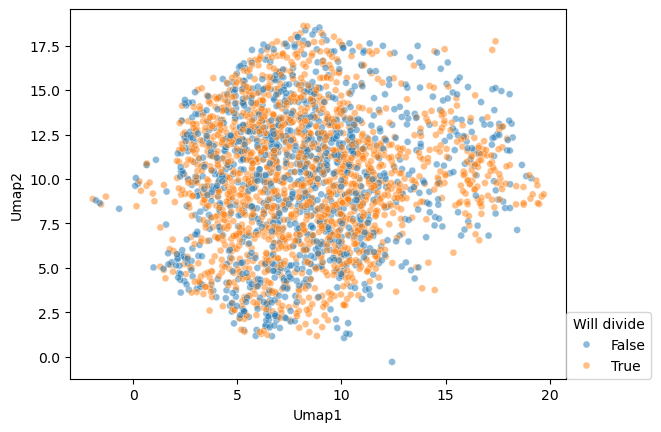

In [626]:
_df = df.droplevel(axis=1,level=1)
_df = _df[_df['Fate known']]
ax = sb.scatterplot( _df,x='Umap1',y='Umap2',hue='Will divide',alpha=0.5)
sb.move_legend(ax,[1,0])

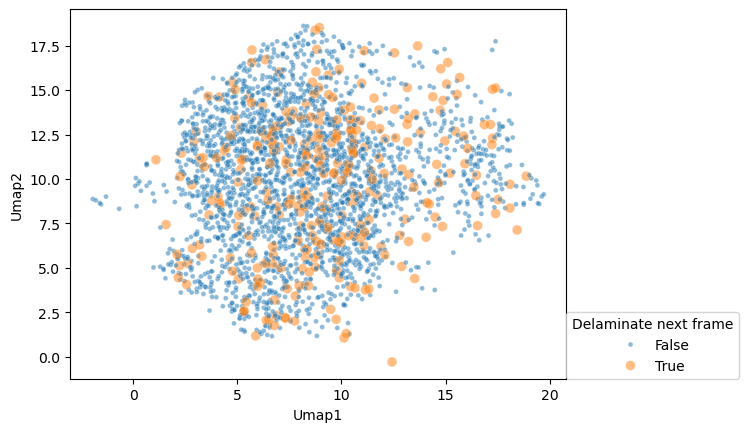

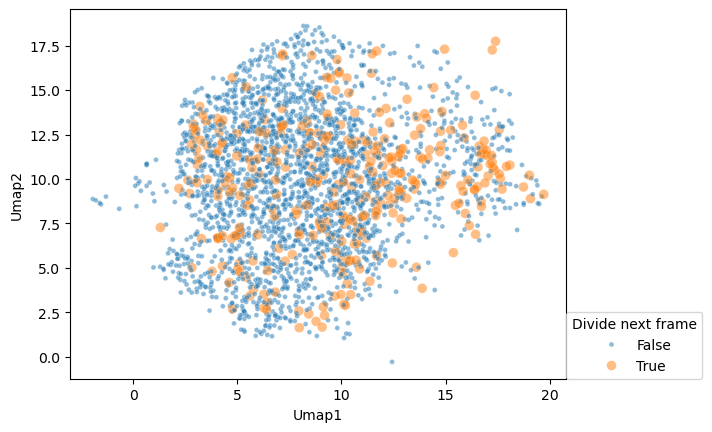

In [632]:
ax = sb.scatterplot( _df,x='Umap1',y='Umap2',hue='Delaminate next frame',alpha=0.5,
              size='Delaminate next frame', size_order=[True,False])
sb.move_legend(ax,[1,0])

plt.figure()
ax = sb.scatterplot( _df,x='Umap1',y='Umap2',hue='Divide next frame',alpha=0.5,
              size='Divide next frame', size_order=[True,False])
sb.move_legend(ax,[1,0])

# PCA

In [603]:
scaled_data

BM height                Height to BM  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -2.255796                    0.639301   
1     1                         -1.861901                    0.460889   
2     1                         -1.074109                    1.055903   
3     1                         -0.286318                    1.260528   
4     1                         -0.680214                    1.709475   
...                                   ...                         ...   
0     1166                      -1.861901                    0.758223   
      1191                      -2.649692                   -1.521773   
      1195                      -1.861901                    0.228229   
      1196                      -1.468005                    0.735781   
      1197                      -2.255796                    0.780995   

              Mean curvature - cell coords Gaussian curvature - cell coords  \
               Measurement tissue geometry      Measurement tissue geometry   
Frame TrackID                                                                 
0     1                          -1.579707                        -0.164560   
1     1                          -1.292504                         0.176855   
2     1                          -1.328134                         0.493168   
3     1                          -1.835271                        -0.015911   
4     1                          -2.049329                         0.106327   
...                                    ...                              ...   
0     1166                       -2.496556                        -0.864284   
      1191                       -1.480231                        -0.442926   
      1195                       -2.418250                        -0.736655   
      1196                       -2.579430                        -0.752901   
      1197                       -2.047841                        -0.158729   

                       Mean curvature 2um      Gaussian curvature 2um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -1.569460                    0.376876   
1     1                         -1.378499                    0.121699   
2     1                         -1.088642                    0.830103   
3     1                         -1.760629                    0.394366   
4     1                         -2.059485                    0.720888   
...                                   ...                         ...   
0     1166                       0.172416                    0.039280   
      1191                       1.160135                    0.102125   
      1195                      -0.528961                    0.784414   
      1196                      -1.056671                    0.611766   
      1197                       0.201162                    0.559076   

                       Mean curvature 5um      Gaussian curvature 5um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -1.916013                    0.599858   
1     1                         -1.713065                    0.245207   
2     1                         -1.745892                    0.252194   
3     1                         -1.283329                   -0.090297   
4     1                         -1.391225                   -0.193614   
...                                   ...                         ...   
0     1166                       0.369719                   -0.192992   
      1191                       0.885398                   -0.055703   
      1195                      -1.346061                    0.498126   
   

In [606]:
from functools import reduce

measurement_types = basals.columns.get_level_values(1)

#Intrinsics
shapes = basals.columns[ (measurement_types.str.contains('shape') | measurement_types.str.contains('shcoeff'))
                         & ~measurement_types.str.contains('adjac') & ~measurement_types.str.contains('elative')]
drop = [f for f in shapes if 'Manual' in f[0]]
shapes = shapes.drop(drop)

position = basals.columns[(measurement_types == 'Measurement cell position')]
h2b = basals.columns[(measurement_types == 'Measurement H2B') | (measurement_types == 'Measurement H2B rate')]
fucci = basals.columns[(measurement_types == 'Measurement FUCCI') | (measurement_types == 'Measurement FUCCI rate')]
intrinsic_features = reduce(list.__add__, [f.tolist() for f in [shapes,position,h2b,fucci]])

# Environment
tissue_geom = basals.columns[measurement_types.str.contains('Measurement tissue geometry')]
collagen = basals.columns[measurement_types.str.contains('ollagen')]
tissue_topo = basals.columns[measurement_types == 'Measurement topology']
adjac_shape = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('shape'))
                | (measurement_types.str.contains('adjac') & measurement_types.str.contains('shcoeff'))]
drop = [f for f in adjac_shape if 'Manual' in f[0]]
adjac_shape = adjac_shape.drop(drop)

adjac_fucci = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('FUCCI'))
                            | (measurement_types.str.contains('relative') & measurement_types.str.contains('FUCCI'))]
adjac_h2b = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('H2B'))
                            | (measurement_types.str.contains('relative') & measurement_types.str.contains('H2B'))]
relative_shape = basals.columns[(measurement_types.str.contains('relative') & measurement_types.str.contains('shape'))
                                 | (measurement_types.str.contains('relative') & measurement_types.str.contains('shcoeff'))]
drop = [f for f in relative_shape if 'Manual' in f[0] or 'rate' in f[0]]
relative_shape = relative_shape.drop(drop)

extrinsic_features = reduce(list.__add__, [f.tolist() for f in [tissue_geom,collagen,tissue_topo,adjac_shape,adjac_fucci,adjac_h2b,relative_shape]])

#Other
times = basals.columns[measurement_types == 'Measurement time']
metas = basals.columns[measurement_types == 'Meta']

# Standardize
extrinsic_measurements = basals[extrinsic_features]
features2drop = extrinsic_measurements.columns[extrinsic_measurements.isna().sum() > 200]
extrinsic_measurements = extrinsic_measurements.drop(columns=features2drop)
extrinsic_measurements = extrinsic_measurements.dropna(axis=0)
extrinsic_measurements['Region'] = basals['Region']

meas_scaled_by_region = scale_by_region(extrinsic_measurements)
scaled_data = meas_scaled_by_region.dropna(axis=0)

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/2673402985.py:72: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/2673402985.py:73: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/466437022.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_ = preprocessing.StandardScaler().fit_transform(scaled_data.drop(columns='Region'))


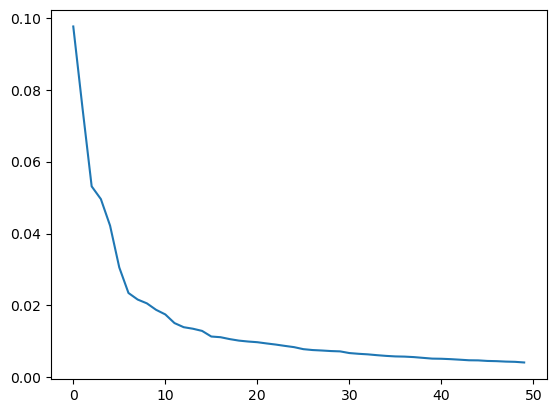

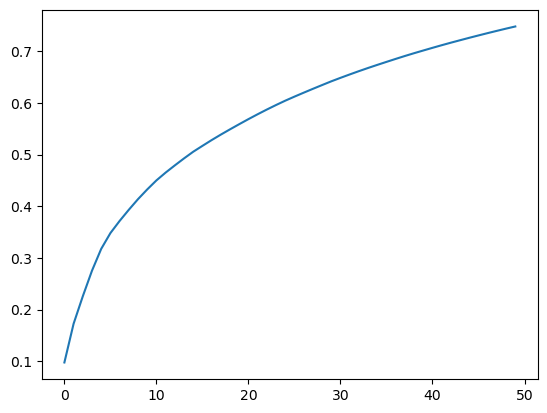

In [607]:
from sklearn import decomposition, preprocessing

N = 50

pca = decomposition.PCA(n_components=N)
X_ = preprocessing.StandardScaler().fit_transform(scaled_data.drop(columns='Region'))
X_ = pca.fit_transform(X_)
X_ = pd.DataFrame(X_,index=scaled_data.index, columns = [f'PC{i}' for i in range (N)])
X_

plt.plot(pca.explained_variance_ratio_)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

components = pca.components_
components = pd.DataFrame(components,index=[f'PC{i}' for i in range (N)],columns=scaled_data.droplevel(axis=1,level=1).columns.drop('Region')).T


In [609]:
components['PC1'].sort_values()

Median adjac Height to BM         -0.110910
Mean adjac Height to BM           -0.110632
Max adjac Height to BM            -0.105252
Std adjac Mean curvature 2um      -0.095099
Max adjac Cell height             -0.094438
                                     ...   
Mean adjac Mean curvature 5um      0.137587
Mean adjac Collagen intensity      0.142543
Median adjac Collagen intensity    0.143889
Median adjac Basal area            0.147225
Mean adjac Basal area              0.158916
Name: PC1, Length: 329, dtype: float64

In [610]:
_df = pd.merge(X_,basals.droplevel(axis=1,level=1)[meta_cols],left_index=True,right_index=True)

_df = _df[_df['Fate known']]

diffs = pd.Series({i:np.diff(_df.groupby('Will divide')[f'PC{i}'].mean())[0] for i in range(N)})
diffs.abs().sort_values()


48    0.020152
44    0.029093
27    0.030510
25    0.041953
38    0.044752
33    0.048210
18    0.048812
12    0.052113
34    0.052798
6     0.064236
20    0.064237
35    0.070410
28    0.073530
17    0.074932
39    0.082364
49    0.090332
11    0.097218
37    0.101384
36    0.102701
45    0.110446
46    0.113497
31    0.119660
43    0.125988
47    0.132610
42    0.138419
23    0.145444
41    0.155016
26    0.177661
40    0.188984
30    0.213076
22    0.216711
3     0.220123
21    0.225017
19    0.237410
29    0.246442
1     0.290622
15    0.292473
32    0.326757
24    0.342726
2     0.454357
4     0.469134
0     0.480958
14    0.521646
13    0.546810
16    0.548796
8     1.124349
10    1.153821
9     1.175100
5     1.281299
7     1.986933
dtype: float64

In [614]:
i = 10

print(_df.groupby('Will divide')[f'PC{i}'].mean())
components[f'PC{i}'].sort_values()


Will divide
False    0.875174
True    -0.278647
Name: PC10, dtype: float64


Relative Mean H2B intensity      -0.154861
Mean adjac shcoeff_PC1           -0.153043
Median adjac shcoeff_PC1         -0.145443
Min adjac shcoeff_PC1            -0.133135
Relative NC ratio                -0.132057
                                    ...   
Relative Planar component 2       0.129818
Relative Total FUCCI intensity    0.140816
Median adjac shcoeff_PC5          0.150341
Relative Height to BM             0.166103
Mean adjac shcoeff_PC5            0.172287
Name: PC10, Length: 329, dtype: float64

In [615]:
components.loc['Mean curvature 5um'].abs().sort_values()

PC32    0.001703
PC21    0.004178
PC13    0.006866
PC44    0.007917
PC15    0.009251
PC35    0.009727
PC25    0.010053
PC3     0.011389
PC8     0.013605
PC24    0.013962
PC27    0.014990
PC47    0.015320
PC49    0.016991
PC45    0.017181
PC20    0.017948
PC23    0.018014
PC18    0.020399
PC17    0.021330
PC19    0.022975
PC38    0.023125
PC36    0.023663
PC7     0.025540
PC16    0.029475
PC30    0.030160
PC33    0.037824
PC31    0.039270
PC39    0.039660
PC41    0.041480
PC11    0.041520
PC26    0.042795
PC22    0.044026
PC14    0.044094
PC4     0.045579
PC2     0.048272
PC10    0.049399
PC0     0.049613
PC37    0.049680
PC48    0.051357
PC46    0.053110
PC42    0.054309
PC43    0.066637
PC5     0.068795
PC12    0.068821
PC9     0.084708
PC40    0.085683
PC34    0.087568
PC1     0.092056
PC6     0.097465
PC28    0.103480
PC29    0.113083
Name: Mean curvature 5um, dtype: float64

In [616]:
from scipy import stats

stats.spearmanr(diffs.abs().sort_values().index,components.loc['Mean curvature 5um'].abs().values.argsort())

SignificanceResult(statistic=np.float64(0.1847298919567827), pvalue=np.float64(0.19904216476531755))